In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
transform = transforms.ToTensor()

In [45]:
train_data = datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='Data', train=False, download=True, transform=transform)

In [46]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [47]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [48]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [49]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Here, we can see that each data point is basically a tuple, 1st item is 28x28 tensor and the 2nd item is label (output).

In [50]:
len(train_data)

60000

In [51]:
image,label = train_data[0]
image.shape

torch.Size([1, 28, 28])

Here 1 shows that it's a gray scale image. Which means there will only be single color channel.

Let's plot this tensor on a 2D scale using plt.imshow(). But, since our image tensor is 3 dimensional we have to reshape it to 2 dimensional.

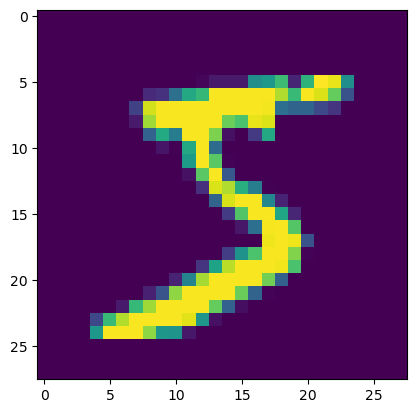

In [52]:
plt.imshow(image.reshape(28,28)) # By default colours

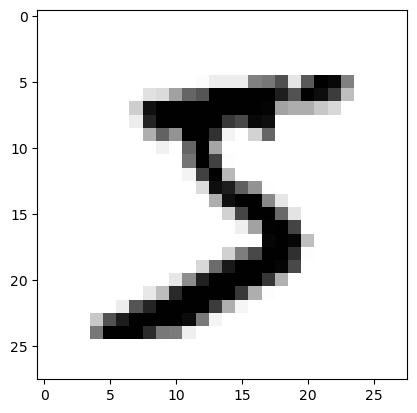

In [53]:
plt.imshow(image.reshape(28,28),cmap = 'gist_yarg')

Now, let's create batches for the datasets as it's a large dataset.

In [54]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 500, shuffle = True)

"shuffle = True" will ensure that the whole data set is shuffled up after each epoch.

In [55]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [56]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's see total number of parmeters we have.

In [57]:
total_param = 0
for param in model.parameters():
    print(param.numel())
    total_param += param.numel()
print(f'total parameters in the NN is : {total_param}')

94080
120
10080
84
840
10
total parameters in the NN is : 105214


It's a huge amount of parameters. Therefore one of the reason to use CNN instead of ANN is that, CNNs reduce **parameter count + capture spatial structure**, while ANNs treat every pixel independently and become huge very quickly.

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [59]:
# Let's check the shape of each batch
for images,label in train_loader:
    break
images.shape

torch.Size([100, 1, 28, 28])

In [60]:
# Flatteing
images.view(100,-1).shape

torch.Size([100, 784])

In [61]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955003  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27258992  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18150841  accuracy:  89.318%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.16269432  accuracy:  94.620%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.07100572  accuracy:  94.948%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.11371274  accuracy:  95.183%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.07406117  accuracy:  96.400%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.16738573  accuracy:  96.590%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.06143294  accuracy:  96.692%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.05556404  accuracy:  97.595%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.13844410  accuracy:  97.517%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.11370134  accuracy:  97.523%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05872302  accuracy:  98.130%
epoch:  4  b

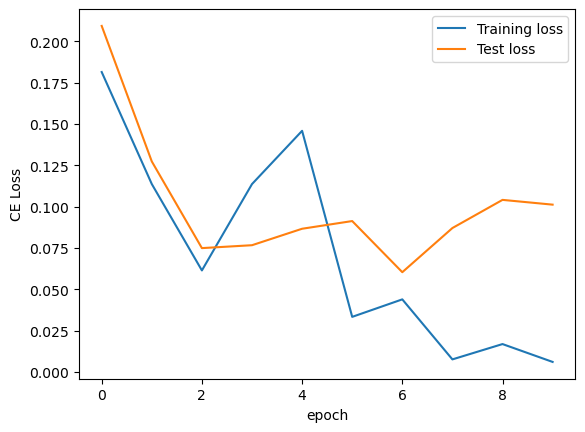

In [65]:
plt.plot(range(epochs), [train_losses[i].detach().numpy() for i in range(len(train_losses))],label = "Training loss")
plt.plot(range(epochs), [test_losses[i].detach().numpy() for i in range(len(test_losses))],label = "Test loss")
plt.ylabel('CE Loss')
plt.xlabel('epoch')
plt.legend()

Running all test data at once with the final weights and biases.

In [67]:
test_data_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [68]:
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_data_all):

            # Apply the model
            y_val = model(X_test.view(len(X_test), -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 

In [69]:
confusion_matrix(y_test, predicted)

array([[ 968,    0,    1,    2,    4,    0,    2,    0,    1,    2],
       [   0, 1127,    0,    0,    0,    0,    3,    1,    4,    0],
       [   1,    2, 1018,    1,    1,    0,    2,    4,    2,    1],
       [   1,    0,    9,  988,    0,    5,    0,    4,    1,    2],
       [   0,    0,    4,    0,  959,    0,    4,    2,    1,   12],
       [   2,    0,    0,   11,    0,  868,    4,    1,    4,    2],
       [   4,    4,    1,    1,    8,    5,  934,    0,    1,    0],
       [   2,    7,   10,    4,    0,    0,    0,  999,    1,    5],
       [   6,    0,    6,   17,    4,    5,    6,    4,  923,    3],
       [   3,    3,    0,    5,    8,    4,    0,    1,    1,  984]])

Here sum will be 10000, as we are running whole data at once.